# Smart Retrieval SLM Analysis

## Hypothesis
**"High-quality retrieval can compensate for smaller, faster LLMs."**

This notebook analyzes experiment results with proper handling of:
- **Stratified sampling** (non-uniform experiment counts)
- **Component-wise effect estimation** with confidence intervals
- **Bottleneck identification** for maximizing QA performance

### Analysis Dimensions
| Dimension | Values | Description |
|-----------|--------|-------------|
| Model | Llama-3.2-3B, Phi-3-mini, Qwen-2.5-3B | Generator LLM |
| Retriever Type | dense, hybrid, hierarchical | Retrieval strategy |
| Embedding Model | bge-large, bge-m3, gte-qwen2, e5-mistral | Embedding model |
| Query Transform | none, hyde, multiquery | Query preprocessing |
| Reranker | none, bge, bge-v2 | Cross-encoder reranking |
| Prompt | concise, structured, cot, fewshot_3 | Prompt template |
| Top-K | 3, 5, 10 | Retrieved documents |
| Dataset | nq, triviaqa, hotpotqa | Evaluation benchmark |

In [1]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Any, Optional, Tuple
from scipy import stats as scipy_stats
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Paths
STUDY_PATH = Path("../outputs/smart_retrieval_slm")

# Metrics to analyze
METRICS = ['f1', 'exact_match', 'bertscore', 'bleurt', 'llm_judge']
PRIMARY_METRIC = 'f1'

print(f"Study path: {STUDY_PATH}")
print(f"Exists: {STUDY_PATH.exists()}")

Study path: ../outputs/smart_retrieval_slm
Exists: True


## 1. Data Loading & Parsing

Parse experiment names following the naming convention:
- Direct: `direct_{model}_{prompt}_{dataset}`
- RAG: `rag_{model}_{retriever}_k{top_k}_{query_transform?}_{reranker?}_{prompt}_{dataset}`

In [2]:
# Model name mappings
MODEL_MAP = {
    'llama': 'Llama-3.2-3B',
    'Llama3.23BInstruct': 'Llama-3.2-3B',
    'phi': 'Phi-3-mini',
    'Phi3mini4kinstruct': 'Phi-3-mini',
    'qwen': 'Qwen-2.5-3B',
    'Qwen2.53BInstruct': 'Qwen-2.5-3B',
}

# Retriever type detection
RETRIEVER_TYPES = {
    'dense': ['dense_bge', 'dense_gte', 'dense_e5', 'en_bge', 'en_gte', 'en_e5'],
    'hybrid': ['hybrid_'],
    'hierarchical': ['hier_', 'hierarchical_'],
}

# Embedding model detection
EMBEDDING_MAP = {
    'bge_large': 'BGE-large',
    'bge_m3': 'BGE-M3',
    'gte_qwen2': 'GTE-Qwen2-1.5B',
    'e5_mistral': 'E5-Mistral-7B',
}


def parse_experiment_name(name: str) -> Dict[str, Any]:
    """Parse experiment name into structured components.
    
    Handles formats:
    - direct_vllm_metallamaLlama3.23BInstruct_concise_nq
    - rag_vllm_metallamaLlama3.23BInstruct_dense_bge_large_512_k5_hyde_bge_concise_nq
    - Singleton experiments (iterative_*, selfrag_*, premium_*)
    """
    config = {
        'name': name,
        'exp_type': 'unknown',
        'model': 'unknown',
        'model_short': 'unknown',
        'dataset': 'unknown',
        'prompt': 'unknown',
        'retriever': None,
        'retriever_type': None,
        'embedding_model': None,
        'top_k': None,
        'query_transform': 'none',
        'reranker': 'none',
        'is_singleton': False,
    }
    
    # Detect dataset (at end of name)
    for ds in ['nq', 'triviaqa', 'hotpotqa']:
        if name.endswith(f'_{ds}'):
            config['dataset'] = ds
            break
    
    # Fallback: look for dataset anywhere in the name
    if config['dataset'] == 'unknown':
        for ds in ['triviaqa', 'hotpotqa', 'nq']:  # nq last since it's short
            if f'_{ds}_' in name or f'_{ds}' in name:
                config['dataset'] = ds
                break
    
    # Handle singleton experiments
    if name.startswith('iterative_') or name.startswith('selfrag_') or name.startswith('premium_'):
        config['is_singleton'] = True
        config['exp_type'] = 'rag'
        if 'llama' in name.lower():
            config['model_short'] = 'Llama-3.2-3B'
        elif 'phi' in name.lower():
            config['model_short'] = 'Phi-3-mini'
        elif 'qwen' in name.lower():
            config['model_short'] = 'Qwen-2.5-3B'
        
        if name.startswith('iterative_'):
            config['retriever_type'] = 'iterative'
            # Parse iterations
            iter_match = re.search(r'(\d+)iter', name)
            config['query_transform'] = f"iterative_{iter_match.group(1)}" if iter_match else 'iterative'
        elif name.startswith('selfrag_'):
            config['retriever_type'] = 'self_rag'
            config['query_transform'] = 'self_rag'
        elif name.startswith('premium_'):
            config['retriever_type'] = 'hybrid'
            config['query_transform'] = 'hyde'
            config['reranker'] = 'bge-v2'
        return config
    
    # Direct experiments
    if name.startswith('direct_'):
        config['exp_type'] = 'direct'
        # Parse model from name
        for key, display in MODEL_MAP.items():
            if key.lower() in name.lower():
                config['model_short'] = display
                break
        # Parse prompt (before dataset)
        for prompt in ['concise', 'structured', 'cot', 'fewshot_3', 'fewshot', 'extractive', 'cited']:
            if f'_{prompt}_' in name or name.endswith(f'_{prompt}_{config["dataset"]}'):
                config['prompt'] = prompt
                break
        return config
    
    # RAG experiments
    if name.startswith('rag_'):
        config['exp_type'] = 'rag'
        
        # Parse model
        for key, display in MODEL_MAP.items():
            if key.lower() in name.lower():
                config['model_short'] = display
                break
        
        # Parse top_k
        k_match = re.search(r'_k(\d+)_', name)
        if k_match:
            config['top_k'] = int(k_match.group(1))
        
        # Parse retriever type and embedding model
        for rtype, patterns in RETRIEVER_TYPES.items():
            for pattern in patterns:
                if pattern in name.lower():
                    config['retriever_type'] = rtype
                    break
        
        for key, display in EMBEDDING_MAP.items():
            if key in name.lower():
                config['embedding_model'] = display
                break
        
        # Parse query transform
        if '_hyde_' in name.lower():
            config['query_transform'] = 'hyde'
        elif '_multiquery_' in name.lower():
            config['query_transform'] = 'multiquery'
        
        # Parse reranker
        if '_bgev2_' in name.lower() or '_bge-v2_' in name.lower():
            config['reranker'] = 'bge-v2'
        elif '_bge_' in name.lower() and config['embedding_model'] is None:
            # bge in name but not as embedding = reranker
            config['reranker'] = 'bge'
        
        # Parse prompt
        for prompt in ['concise', 'structured', 'cot', 'fewshot_3', 'fewshot', 'extractive', 'cited']:
            if f'_{prompt}_' in name:
                config['prompt'] = prompt
                break
        
        # Extract full retriever name
        # Pattern: after model, before _k{n}_
        if k_match:
            retriever_match = re.search(r'Instruct_(.+?)_k\d+', name)
            if retriever_match:
                config['retriever'] = retriever_match.group(1)
    
    return config


def load_all_results(study_path: Path) -> pd.DataFrame:
    """Load all experiment results into a DataFrame."""
    results = []
    loading_errors = []
    
    if not study_path.exists():
        print(f"Warning: Study path does not exist: {study_path}")
        return pd.DataFrame()
    
    for exp_dir in study_path.iterdir():
        if not exp_dir.is_dir():
            continue
        
        # Try results.json first, then metadata.json
        results_file = exp_dir / "results.json"
        metadata_file = exp_dir / "metadata.json"
        
        data = None
        if results_file.exists():
            with open(results_file) as f:
                data = json.load(f)
        elif metadata_file.exists():
            with open(metadata_file) as f:
                data = json.load(f)
            # Also load summary if exists
            summary_files = list(exp_dir.glob("*_summary.json"))
            if summary_files:
                with open(summary_files[0]) as f:
                    summary = json.load(f)
                data['metrics'] = summary.get('overall_metrics', summary)
        
        if data is None:
            continue
        
        try:
            # Parse experiment name
            exp_name = data.get('name', exp_dir.name)
            config = parse_experiment_name(exp_name)
            
            # Add metrics
            row = config.copy()
            metrics = data.get('metrics', data)
            
            # Handle case where metrics is a list (e.g., per-sample metrics)
            if isinstance(metrics, list):
                # Try to find overall_metrics in the data instead
                metrics = data.get('overall_metrics', {})
            
            # Handle case where metrics is nested under another key
            if not isinstance(metrics, dict):
                metrics = {}
            
            for metric in METRICS:
                if metric in metrics:
                    row[metric] = metrics[metric]
                elif metric in data:
                    row[metric] = data[metric]
            
            # Add sample count and timing
            row['n_samples'] = data.get('n_samples', data.get('num_questions', None))
            row['duration'] = data.get('duration', 0)
            row['throughput'] = data.get('throughput_qps', 0)
            
            results.append(row)
        except Exception as e:
            loading_errors.append((exp_dir.name, str(e)))
    
    # Report loading errors
    if loading_errors:
        print(f"⚠️ Failed to load {len(loading_errors)} experiments:")
        for name, error in loading_errors:
            print(f"   {name}: {error}")
        print()
    
    df = pd.DataFrame(results)
    if not df.empty:
        df = df.sort_values(['exp_type', 'model_short', 'dataset']).reset_index(drop=True)
    
    return df


# Load data
df = load_all_results(STUDY_PATH)
print(f"Loaded {len(df)} experiments")

if len(df) > 0:
    print(f"\nExperiment types: {df['exp_type'].value_counts().to_dict()}")
    print(f"Models: {sorted(df['model_short'].dropna().unique())}")
    print(f"Datasets: {sorted(df['dataset'].dropna().unique())}")
    print(f"Retriever types: {df['retriever_type'].dropna().unique().tolist()}")
    print(f"\nMetrics available: {[m for m in METRICS if m in df.columns]}")

Error loading rag_vllm_microsoft_Phi3mini4kinstruct_hier_bge_large_2048p_448c_k10_hyde_bge_structured_hotpotqa: list indices must be integers or slices, not str
Error loading rag_vllm_microsoft_Phi3mini4kinstruct_hier_bge_large_2048p_448c_k5_multiquery_bge_fewshot_3_nq: list indices must be integers or slices, not str
Error loading rag_vllm_Qwen_Qwen2.53BInstruct_hier_bge_large_2048p_448c_k5_bge-v2_fewshot_3_triviaqa: list indices must be integers or slices, not str
Error loading rag_vllm_microsoft_Phi3mini4kinstruct_hier_bge_large_2048p_448c_k10_bge_concise_triviaqa: list indices must be integers or slices, not str
Loaded 114 experiments

Experiment types: {'rag': 96, 'direct': 18}
Models: ['Llama-3.2-3B', 'Phi-3-mini', 'Qwen-2.5-3B']
Datasets: ['hotpotqa', 'nq', 'triviaqa', 'unknown']
Retriever types: ['dense', 'hybrid', 'hierarchical']

Metrics available: ['f1', 'exact_match', 'bleurt']


In [ ]:
# Data Quality Check
if len(df) > 0:
    print("Data Quality Check")
    print("="*60)
    
    # Check for unknown datasets
    unknown_ds = df[df['dataset'] == 'unknown']
    if len(unknown_ds) > 0:
        print(f"\n⚠️ Found {len(unknown_ds)} experiments with 'unknown' dataset:")
        for _, row in unknown_ds.iterrows():
            print(f"   {row['name']}")
        print("\n   → These need fixing in parse_experiment_name() or experiment naming.")
    else:
        print("\n✅ All experiments have known datasets.")
    
    # Check for unknown models
    unknown_model = df[df['model_short'] == 'unknown']
    if len(unknown_model) > 0:
        print(f"\n⚠️ Found {len(unknown_model)} experiments with 'unknown' model:")
        for _, row in unknown_model.iterrows():
            print(f"   {row['name']}")
    else:
        print("✅ All experiments have known models.")
    
    # Check for missing metrics
    missing_metric = df[PRIMARY_METRIC].isna()
    if missing_metric.sum() > 0:
        print(f"\n⚠️ Found {missing_metric.sum()} experiments with missing {PRIMARY_METRIC}.")
    else:
        print(f"✅ All experiments have {PRIMARY_METRIC} metric.")

In [3]:
# Show experiment distribution (important for stratified sampling)
if len(df) > 0:
    print("Experiment Distribution (crucial for weighted analysis)")
    print("="*60)
    
    # By key dimensions
    for dim in ['model_short', 'retriever_type', 'query_transform', 'reranker', 'prompt', 'dataset']:
        if dim in df.columns:
            counts = df[dim].value_counts()
            print(f"\n{dim}:")
            for val, count in counts.items():
                print(f"  {val}: {count}")

Experiment Distribution (crucial for weighted analysis)

model_short:
  Llama-3.2-3B: 42
  Qwen-2.5-3B: 38
  Phi-3-mini: 34

retriever_type:
  dense: 53
  hybrid: 35
  hierarchical: 8

query_transform:
  none: 57
  hyde: 35
  multiquery: 22

reranker:
  none: 89
  bge-v2: 25

prompt:
  concise: 54
  fewshot_3: 25
  cot: 18
  structured: 17

dataset:
  hotpotqa: 41
  nq: 36
  triviaqa: 28
  unknown: 9


## 2. Weighted Analysis Functions

With stratified sampling, we have non-uniform experiment counts.
We use **inverse frequency weighting** and **bootstrap confidence intervals**.

In [4]:
def weighted_mean_with_ci(
    df: pd.DataFrame, 
    group_col: str, 
    metric: str = PRIMARY_METRIC,
    weight_by: str = None,
    confidence: float = 0.95,
    n_bootstrap: int = 1000,
) -> pd.DataFrame:
    """
    Compute weighted mean with bootstrap confidence intervals.
    
    Args:
        df: DataFrame with experiment results
        group_col: Column to group by
        metric: Metric to analyze
        weight_by: Column to use for inverse frequency weighting (e.g., 'dataset')
        confidence: Confidence level for CI
        n_bootstrap: Number of bootstrap samples
    """
    if metric not in df.columns:
        return pd.DataFrame()
    
    results = []
    
    for group_val, group_df in df.groupby(group_col):
        values = group_df[metric].dropna().values
        if len(values) == 0:
            continue
        
        # Compute weights if specified
        if weight_by and weight_by in group_df.columns:
            # Inverse frequency weighting
            weight_counts = group_df[weight_by].value_counts()
            weights = group_df[weight_by].map(lambda x: 1.0 / weight_counts.get(x, 1))
            weights = weights / weights.sum()  # Normalize
            weighted_mean = (group_df[metric] * weights).sum()
        else:
            weighted_mean = np.mean(values)
            weights = None
        
        # Bootstrap CI
        if len(values) >= 3:
            bootstrap_means = []
            for _ in range(n_bootstrap):
                sample = np.random.choice(values, size=len(values), replace=True)
                bootstrap_means.append(np.mean(sample))
            alpha = (1 - confidence) / 2
            ci_low = np.percentile(bootstrap_means, alpha * 100)
            ci_high = np.percentile(bootstrap_means, (1 - alpha) * 100)
        else:
            ci_low = ci_high = weighted_mean
        
        results.append({
            group_col: group_val,
            'mean': weighted_mean,
            'std': np.std(values) if len(values) > 1 else 0,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'n': len(values),
            'min': np.min(values),
            'max': np.max(values),
        })
    
    return pd.DataFrame(results).sort_values('mean', ascending=False).reset_index(drop=True)


def effect_size(baseline_values: np.ndarray, treatment_values: np.ndarray) -> Tuple[float, float, str]:
    """
    Compute Cohen's d effect size and interpret it.
    
    Returns: (effect_size, p_value, interpretation)
    """
    if len(baseline_values) < 2 or len(treatment_values) < 2:
        return 0, 1, 'insufficient data'
    
    # Cohen's d
    pooled_std = np.sqrt((
        (len(baseline_values) - 1) * np.var(baseline_values, ddof=1) + 
        (len(treatment_values) - 1) * np.var(treatment_values, ddof=1)
    ) / (len(baseline_values) + len(treatment_values) - 2))
    
    if pooled_std == 0:
        return 0, 1, 'no variance'
    
    d = (np.mean(treatment_values) - np.mean(baseline_values)) / pooled_std
    
    # t-test
    t_stat, p_value = scipy_stats.ttest_ind(treatment_values, baseline_values)
    
    # Interpret
    if abs(d) < 0.2:
        interpretation = 'negligible'
    elif abs(d) < 0.5:
        interpretation = 'small'
    elif abs(d) < 0.8:
        interpretation = 'medium'
    else:
        interpretation = 'large'
    
    return d, p_value, interpretation


def compute_marginal_means(
    df: pd.DataFrame,
    factor: str,
    metric: str = PRIMARY_METRIC,
    control_vars: List[str] = ['model_short', 'dataset'],
) -> pd.DataFrame:
    """
    Compute marginal means for a factor, controlling for confounding variables.
    
    This averages performance within each stratum (combination of control_vars)
    and then averages across strata - properly controlling for confounders.
    
    Args:
        df: DataFrame with experiment results
        factor: The factor to analyze (e.g., 'retriever_type')
        metric: Metric to analyze
        control_vars: Variables to control for (model, dataset)
    
    Returns:
        DataFrame with marginal means and CIs for each factor level
    """
    if metric not in df.columns or factor not in df.columns:
        return pd.DataFrame()
    
    # Filter to rows with all needed columns
    needed_cols = [factor, metric] + [c for c in control_vars if c in df.columns]
    work_df = df[needed_cols].dropna()
    
    if len(work_df) < 5:
        return pd.DataFrame()
    
    # Create strata
    strata_cols = [c for c in control_vars if c in work_df.columns]
    if strata_cols:
        work_df['_stratum'] = work_df[strata_cols].apply(lambda x: '_'.join(x.astype(str)), axis=1)
    else:
        work_df['_stratum'] = 'all'
    
    # For each factor level, compute mean within each stratum, then average
    results = []
    factor_levels = work_df[factor].dropna().unique()
    
    for level in factor_levels:
        level_df = work_df[work_df[factor] == level]
        
        # Compute mean within each stratum
        stratum_means = level_df.groupby('_stratum')[metric].mean()
        
        if len(stratum_means) == 0:
            continue
        
        # Marginal mean = average of stratum means (equal weight per stratum)
        marginal_mean = stratum_means.mean()
        
        # Bootstrap CI on the marginal mean
        all_values = level_df[metric].values
        if len(all_values) >= 3:
            bootstrap_means = []
            for _ in range(500):
                sample = np.random.choice(all_values, size=len(all_values), replace=True)
                bootstrap_means.append(np.mean(sample))
            ci_low = np.percentile(bootstrap_means, 2.5)
            ci_high = np.percentile(bootstrap_means, 97.5)
        else:
            ci_low = ci_high = marginal_mean
        
        results.append({
            factor: level,
            'marginal_mean': marginal_mean,
            'raw_mean': level_df[metric].mean(),
            'ci_low': ci_low,
            'ci_high': ci_high,
            'n_experiments': len(level_df),
            'n_strata': len(stratum_means),
        })
    
    result_df = pd.DataFrame(results)
    if not result_df.empty:
        result_df = result_df.sort_values('marginal_mean', ascending=False).reset_index(drop=True)
    return result_df


def analyze_factor_controlled(
    df: pd.DataFrame,
    factor: str,
    metric: str = PRIMARY_METRIC,
    control_vars: List[str] = ['model_short', 'dataset'],
    baseline: str = None,
) -> pd.DataFrame:
    """
    Analyze factor effects with proper confound control.
    
    Computes effect sizes for each level vs baseline, controlling for
    model and dataset by computing within-stratum effects.
    """
    if factor not in df.columns or metric not in df.columns:
        return pd.DataFrame()
    
    # Get marginal means
    marginal = compute_marginal_means(df, factor, metric, control_vars)
    if marginal.empty:
        return pd.DataFrame()
    
    # Determine baseline
    if baseline is None:
        # Use most common or first level
        baseline = df[factor].value_counts().index[0]
    
    if baseline not in marginal[factor].values:
        baseline = marginal[factor].iloc[0]
    
    baseline_mean = marginal[marginal[factor] == baseline]['marginal_mean'].values[0]
    baseline_values = df[df[factor] == baseline][metric].dropna().values
    
    # Compute effects vs baseline
    results = []
    for _, row in marginal.iterrows():
        level = row[factor]
        level_values = df[df[factor] == level][metric].dropna().values
        
        delta = row['marginal_mean'] - baseline_mean
        
        # Effect size
        d, p_val, interp = effect_size(baseline_values, level_values)
        
        results.append({
            factor: level,
            'marginal_mean': row['marginal_mean'],
            'vs_baseline': delta,
            'pct_change': delta / baseline_mean * 100 if baseline_mean != 0 else 0,
            'effect_size': d,
            'p_value': p_val,
            'significance': '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else '',
            'n': row['n_experiments'],
            'n_strata': row['n_strata'],
            'is_baseline': level == baseline,
        })
    
    return pd.DataFrame(results).sort_values('marginal_mean', ascending=False).reset_index(drop=True)

## 3. RAG vs Direct LLM Analysis

In [5]:
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    direct_df = df[df['exp_type'] == 'direct']
    rag_df = df[df['exp_type'] == 'rag']
    
    print("RAG vs Direct LLM Comparison")
    print("="*60)
    
    if len(direct_df) > 0 and len(rag_df) > 0:
        direct_mean = direct_df[PRIMARY_METRIC].mean()
        rag_mean = rag_df[PRIMARY_METRIC].mean()
        
        d, p, interp = effect_size(
            direct_df[PRIMARY_METRIC].dropna().values,
            rag_df[PRIMARY_METRIC].dropna().values
        )
        
        print(f"Direct LLM: {direct_mean:.4f} (n={len(direct_df)})")
        print(f"RAG:        {rag_mean:.4f} (n={len(rag_df)})")
        print(f"\nImprovement: {rag_mean - direct_mean:+.4f} ({(rag_mean/direct_mean - 1)*100:+.1f}%)")
        print(f"Effect size (Cohen's d): {d:.3f} ({interp})")
        print(f"P-value: {p:.4f} {'✓ significant' if p < 0.05 else '✗ not significant'}")
    else:
        print("Need both direct and RAG experiments for comparison")

RAG vs Direct LLM Comparison
Direct LLM: 0.1446 (n=18)
RAG:        0.1050 (n=96)

Improvement: -0.0397 (-27.4%)
Effect size (Cohen's d): -0.285 (small)
P-value: 0.2696 ✗ not significant



RAG vs Direct by Model × Dataset


,model,dataset,direct,rag_mean,rag_best,improvement,n_rag
0,Llama-3.2-3B,hotpotqa,0.1995,0.1130,0.1805,-0.0864,14
1,Llama-3.2-3B,nq,0.2607,0.1895,0.2612,-0.0712,13
2,Llama-3.2-3B,triviaqa,0.5664,0.4104,0.5492,-0.1561,9
3,Phi-3-mini,hotpotqa,0.0064,0.0075,0.0138,0.0011,10
4,Phi-3-mini,nq,0.0164,0.0105,0.0217,-0.0059,13
5,Phi-3-mini,triviaqa,0.0140,0.0186,0.0261,0.0046,5
6,Qwen-2.5-3B,hotpotqa,0.0874,0.0347,0.1101,-0.0527,14
7,Qwen-2.5-3B,nq,0.0724,0.0707,0.2018,-0.0017,7
8,Qwen-2.5-3B,triviaqa,0.2349,0.0958,0.3143,-0.1392,11


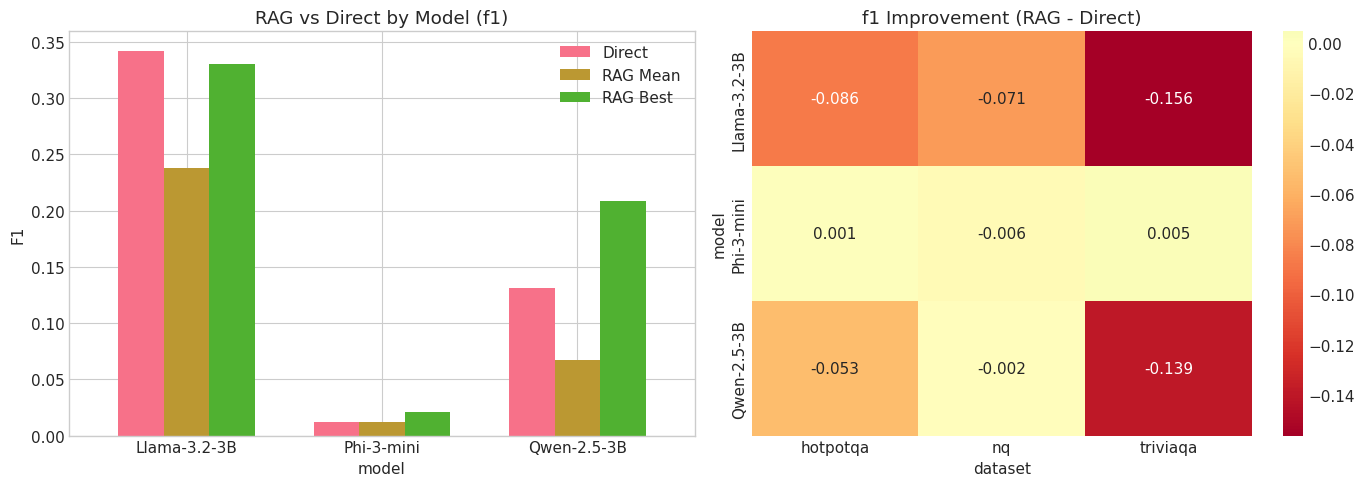

In [6]:
# RAG vs Direct by model and dataset
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    direct_df = df[df['exp_type'] == 'direct']
    rag_df = df[df['exp_type'] == 'rag']
    
    if len(direct_df) > 0 and len(rag_df) > 0:
        comparisons = []
        for model in df['model_short'].dropna().unique():
            for dataset in df['dataset'].dropna().unique():
                direct_vals = direct_df[(direct_df['model_short'] == model) & 
                                        (direct_df['dataset'] == dataset)][PRIMARY_METRIC].dropna()
                rag_vals = rag_df[(rag_df['model_short'] == model) & 
                                  (rag_df['dataset'] == dataset)][PRIMARY_METRIC].dropna()
                
                if len(direct_vals) > 0 and len(rag_vals) > 0:
                    comparisons.append({
                        'model': model,
                        'dataset': dataset,
                        'direct': direct_vals.mean(),
                        'rag_mean': rag_vals.mean(),
                        'rag_best': rag_vals.max(),
                        'improvement': rag_vals.mean() - direct_vals.mean(),
                        'n_rag': len(rag_vals),
                    })
        
        if comparisons:
            comp_df = pd.DataFrame(comparisons)
            print("\nRAG vs Direct by Model × Dataset")
            display(comp_df.round(4))
            
            # Visualize
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Grouped bar by model
            model_comp = comp_df.groupby('model').agg({
                'direct': 'mean',
                'rag_mean': 'mean',
                'rag_best': 'mean',
            })
            model_comp.plot(kind='bar', ax=axes[0], width=0.7)
            axes[0].set_title(f'RAG vs Direct by Model ({PRIMARY_METRIC})')
            axes[0].set_ylabel(PRIMARY_METRIC.upper())
            axes[0].legend(['Direct', 'RAG Mean', 'RAG Best'])
            axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
            
            # Improvement heatmap
            pivot = comp_df.pivot(index='model', columns='dataset', values='improvement')
            sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', center=0, ax=axes[1])
            axes[1].set_title(f'{PRIMARY_METRIC} Improvement (RAG - Direct)')
            
            plt.tight_layout()
            plt.show()

## 4. Component Effect Analysis

Analyze the marginal effect of each component while controlling for others.

In [7]:
def analyze_component_effects(
    df: pd.DataFrame,
    metric: str = PRIMARY_METRIC,
    components: List[str] = None,
    control_for: List[str] = ['model_short', 'dataset'],
) -> pd.DataFrame:
    """
    Analyze the effect of each RAG component on the metric.
    
    IMPORTANT: This now uses CONTROLLED analysis - effects are computed
    using marginal means that average across model/dataset strata.
    This removes confounding from these external factors.
    
    Args:
        df: DataFrame with experiment results
        metric: Metric to analyze
        components: RAG components to analyze (excluding confounders)
        control_for: Variables to control for (default: model, dataset)
    """
    if components is None:
        # Only RAG-specific components - NOT model/dataset
        components = ['retriever_type', 'embedding_model', 
                      'query_transform', 'reranker', 'prompt', 'top_k']
    
    rag_df = df[df['exp_type'] == 'rag'].copy()
    # Filter out unknown datasets
    rag_df = rag_df[rag_df['dataset'] != 'unknown']
    
    if metric not in rag_df.columns or len(rag_df) == 0:
        return pd.DataFrame()
    
    all_effects = []
    
    for comp in components:
        if comp not in rag_df.columns or comp in control_for:
            continue
        
        # Use the controlled analysis function
        controlled = analyze_factor_controlled(rag_df, comp, metric, control_for)
        if controlled.empty:
            continue
        
        # Find baseline
        baseline_row = controlled[controlled['is_baseline']]
        if baseline_row.empty:
            continue
        baseline_val = baseline_row[comp].iloc[0]
        baseline_mean = baseline_row['marginal_mean'].iloc[0]
        
        for _, row in controlled.iterrows():
            if row['is_baseline']:
                continue
            
            all_effects.append({
                'component': comp,
                'baseline': baseline_val,
                'treatment': row[comp],
                'baseline_mean': baseline_mean,
                'treatment_mean': row['marginal_mean'],
                'improvement': row['vs_baseline'],
                'pct_change': row['pct_change'],
                'effect_size': row['effect_size'],
                'p_value': row['p_value'],
                'significant': row['p_value'] < 0.05,
                'n_strata': row['n_strata'],
                'n_experiments': row['n'],
            })
    
    result = pd.DataFrame(all_effects)
    if not result.empty:
        result = result.sort_values('effect_size', ascending=False).reset_index(drop=True)
    return result


if len(df) > 0 and PRIMARY_METRIC in df.columns:
    effects_df = analyze_component_effects(df)
    if len(effects_df) > 0:
        print(f"RAG Component Effects on {PRIMARY_METRIC} (Controlled for Model/Dataset)")
        print("="*80)
        print("Effects computed using MARGINAL MEANS across model/dataset strata.")
        print("This removes confounding from these external factors.\n")
        print("Positive effect_size = treatment better than baseline\n")
        display(effects_df[['component', 'baseline', 'treatment', 'improvement', 
                           'pct_change', 'effect_size', 'p_value', 'significant', 
                           'n_strata', 'n_experiments']].round(4))

Component Effects on f1
Positive effect_size = treatment better than baseline



,component,baseline,treatment,improvement,effect_size,effect_interp,p_value,significant,n_baseline,n_treatment
0,prompt,concise,fewshot_3,0.0768,0.5088,medium,0.0857,False,45,16
1,retriever_type,dense,hierarchical,0.0676,0.4695,small,0.2207,False,53,8
2,top_k,3.0,5.0,0.0119,0.0820,negligible,0.7274,False,38,35
3,prompt,concise,structured,-0.0100,-0.0793,negligible,0.7817,False,45,17
4,top_k,3.0,10.0,-0.0102,-0.0837,negligible,0.7525,False,38,23
5,reranker,none,bge-v2,-0.0115,-0.0850,negligible,0.7154,False,71,25
6,retriever_type,dense,hybrid,-0.0163,-0.1320,negligible,0.5461,False,53,35
7,embedding_model,BGE-large,BGE-M3,-0.0264,-0.1842,negligible,0.5228,False,43,17
8,embedding_model,BGE-large,GTE-Qwen2-1.5B,-0.0307,-0.2206,small,0.3319,False,43,36
9,query_transform,none,hyde,-0.0321,-0.2289,small,0.3289,False,39,35


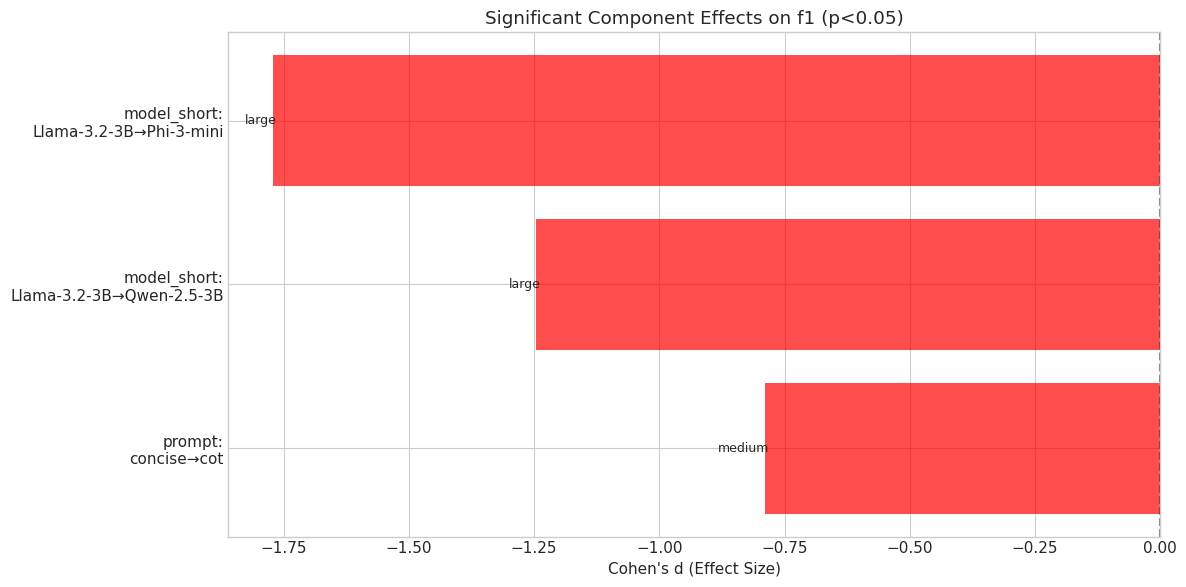

In [8]:
# Visualize component effects
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    effects_df = analyze_component_effects(df)
    if len(effects_df) > 0:
        # Filter to significant effects
        sig_effects = effects_df[effects_df['significant']].copy()
        
        if len(sig_effects) > 0:
            fig, ax = plt.subplots(figsize=(12, 6))
            
            # Create labels
            sig_effects['label'] = sig_effects.apply(
                lambda r: f"{r['component']}:\n{r['baseline']}→{r['treatment']}", axis=1
            )
            
            colors = ['green' if x > 0 else 'red' for x in sig_effects['effect_size']]
            
            bars = ax.barh(sig_effects['label'], sig_effects['effect_size'], color=colors, alpha=0.7)
            ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
            ax.set_xlabel("Cohen's d (Effect Size)")
            ax.set_title(f"Significant Component Effects on {PRIMARY_METRIC} (p<0.05)")
            
            # Add effect size labels
            for bar, es in zip(bars, sig_effects['effect_size']):
                width = bar.get_width()
                # Interpret effect size
                interp = 'negligible' if abs(es) < 0.2 else 'small' if abs(es) < 0.5 else 'medium' if abs(es) < 0.8 else 'large'
                ax.annotate(f'{interp}',
                           xy=(width, bar.get_y() + bar.get_height()/2),
                           xytext=(3, 0), textcoords='offset points',
                           ha='left' if width > 0 else 'right', va='center', fontsize=9)
            
            plt.tight_layout()
            plt.show()
        else:
            print("No statistically significant effects found (p<0.05)")

## 5. Model Comparison (with non-uniform weighting)

Model Comparison (weighted by dataset)


,model_short,mean,std,ci_low,ci_high,n,min,max
0,Llama-3.2-3B,0.2376,0.1511,0.1675,0.2669,36,0.0166,0.5492
1,Qwen-2.5-3B,0.0671,0.0690,0.0417,0.0879,32,0.0093,0.3143
2,Phi-3-mini,0.0122,0.0056,0.0090,0.0129,28,0.0049,0.0261


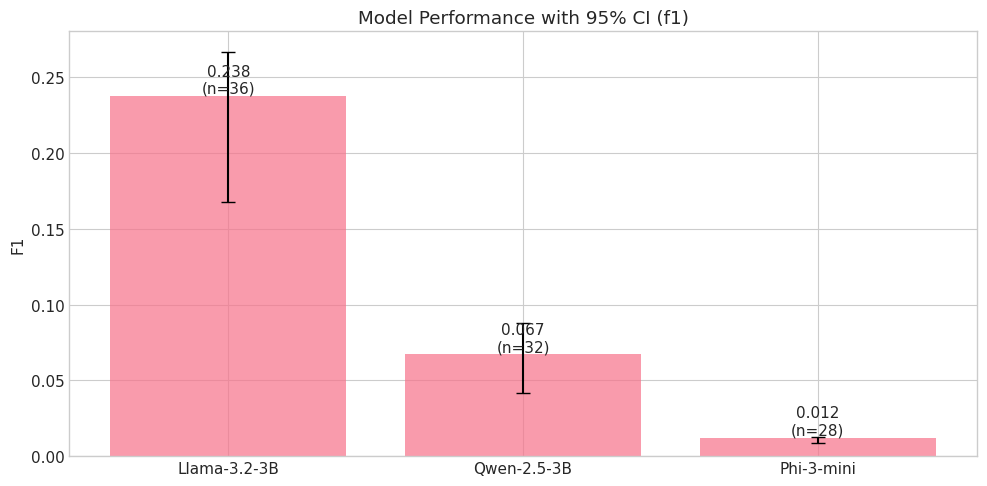

In [9]:
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    rag_df = df[df['exp_type'] == 'rag']
    
    if len(rag_df) > 0:
        # Weighted by dataset to account for non-uniform sampling
        model_stats = weighted_mean_with_ci(rag_df, 'model_short', PRIMARY_METRIC, weight_by='dataset')
        
        print(f"Model Comparison (weighted by dataset)")
        print("="*60)
        display(model_stats.round(4))
        
        # Visualize with error bars
        fig, ax = plt.subplots(figsize=(10, 5))
        
        x = range(len(model_stats))
        ax.bar(x, model_stats['mean'], 
               yerr=[model_stats['mean'] - model_stats['ci_low'], 
                     model_stats['ci_high'] - model_stats['mean']],
               capsize=5, alpha=0.7)
        ax.set_xticks(x)
        ax.set_xticklabels(model_stats['model_short'])
        ax.set_ylabel(PRIMARY_METRIC.upper())
        ax.set_title(f'Model Performance with 95% CI ({PRIMARY_METRIC})')
        
        for i, row in model_stats.iterrows():
            ax.annotate(f"{row['mean']:.3f}\n(n={row['n']})",
                       xy=(i, row['mean']), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()

## 5.5 Controlled RAG Analysis (Segmented by Model & Dataset)

Model and dataset are **confounding factors** for measuring RAG component effects.
Different models have different capabilities, and different datasets have different difficulties.

This section provides analysis **within each model-dataset combination** to isolate RAG-specific effects.

In [ ]:
# Controlled analysis: RAG component effects within each model-dataset combination
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    rag_df = df[df['exp_type'] == 'rag'].copy()
    
    # Only analyze if we have non-unknown datasets
    rag_df_clean = rag_df[rag_df['dataset'] != 'unknown']
    
    if len(rag_df_clean) > 0:
        print("Controlled RAG Analysis (within Model × Dataset)")
        print("="*70)
        print("This removes model/dataset confounding to measure pure RAG effects.\n")
        
        # For each dataset, analyze RAG components
        for dataset in sorted(rag_df_clean['dataset'].unique()):
            ds_df = rag_df_clean[rag_df_clean['dataset'] == dataset]
            if len(ds_df) < 3:
                continue
            
            print(f"\n{'='*40}")
            print(f"Dataset: {dataset.upper()} (n={len(ds_df)} experiments)")
            print(f"{'='*40}")
            
            # For each RAG component, show effect within this dataset
            for comp in ['retriever_type', 'embedding_model', 'query_transform', 'reranker']:
                if comp not in ds_df.columns:
                    continue
                comp_vals = ds_df[comp].dropna().unique()
                if len(comp_vals) < 2:
                    continue
                    
                stats = ds_df.groupby(comp)[PRIMARY_METRIC].agg(['mean', 'std', 'count'])
                stats = stats.sort_values('mean', ascending=False)
                best = stats.index[0]
                best_val = stats.loc[best, 'mean']
                
                print(f"\n  {comp}:")
                for val in stats.index:
                    mean = stats.loc[val, 'mean']
                    n = stats.loc[val, 'count']
                    marker = ' ★' if val == best else ''
                    print(f"    {val}: {mean:.4f} (n={n}){marker}")
        
        # Summary: Best configuration per dataset
        print("\n" + "="*70)
        print("BEST CONFIGURATION PER DATASET")
        print("="*70)
        for dataset in sorted(rag_df_clean['dataset'].unique()):
            ds_df = rag_df_clean[rag_df_clean['dataset'] == dataset]
            if len(ds_df) == 0:
                continue
            best_idx = ds_df[PRIMARY_METRIC].idxmax()
            best = ds_df.loc[best_idx]
            print(f"\n{dataset}: {PRIMARY_METRIC}={best[PRIMARY_METRIC]:.4f}")
            print(f"  Retriever: {best.get('retriever_type', 'N/A')} / {best.get('embedding_model', 'N/A')}")
            print(f"  Query: {best.get('query_transform', 'none')}, Reranker: {best.get('reranker', 'none')}")

## 6. Retrieval Strategy Comparison

In [10]:
# Controlled analysis - uses marginal means that average across model/dataset strata
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    rag_df = df[df['exp_type'] == 'rag']
    # Filter out unknown datasets
    rag_df = rag_df[rag_df['dataset'] != 'unknown']
    
    print("CONTROLLED Retrieval Strategy Analysis")
    print("="*60)
    print("Using MARGINAL MEANS that average across model/dataset strata.")
    print("This removes confounding from these external factors.\n")
    
    for dimension in ['retriever_type', 'embedding_model', 'query_transform', 'reranker', 'top_k']:
        if dimension not in rag_df.columns:
            continue
        if rag_df[dimension].dropna().nunique() < 2:
            continue
        
        # Use controlled marginal means
        stats = compute_marginal_means(rag_df, dimension, PRIMARY_METRIC, control_vars=['model_short', 'dataset'])
        
        if len(stats) > 0:
            print(f"\n{dimension.replace('_', ' ').title()}")
            print("-"*50)
            display(stats.round(4))


Retriever Type
--------------------------------------------------


,retriever_type,mean,std,ci_low,ci_high,n,min,max
0,hierarchical,0.2104,0.2091,0.0263,0.3212,8,0.0110,0.5492
1,dense,0.1084,0.1284,0.0729,0.1419,53,0.0050,0.5030
2,hybrid,0.1031,0.1126,0.0547,0.1283,35,0.0049,0.4520



Embedding Model
--------------------------------------------------


,embedding_model,mean,std,ci_low,ci_high,n,min,max
0,BGE-large,0.1406,0.1521,0.0808,0.1670,43,0.0068,0.5492
1,GTE-Qwen2-1.5B,0.0982,0.1178,0.0566,0.1292,36,0.0049,0.4570
2,BGE-M3,0.0913,0.1081,0.0466,0.1508,17,0.0050,0.3773



Query Transform
--------------------------------------------------


,query_transform,mean,std,ci_low,ci_high,n,min,max
0,none,0.1463,0.1594,0.0798,0.1862,39,0.0049,0.5492
1,hyde,0.1003,0.1098,0.0639,0.1332,35,0.0063,0.4309
2,multiquery,0.0944,0.1090,0.0379,0.1289,22,0.0068,0.4708



Reranker
--------------------------------------------------


,reranker,mean,std,ci_low,ci_high,n,min,max
0,bge-v2,0.1214,0.1131,0.0585,0.1401,25,0.0050,0.4708
1,none,0.1124,0.1400,0.0776,0.1418,71,0.0049,0.5492



Top K
--------------------------------------------------


,top_k,mean,std,ci_low,ci_high,n,min,max
0,5.0,0.1258,0.1536,0.0685,0.1691,35,0.0050,0.5492
1,3.0,0.1181,0.1340,0.0649,0.1504,38,0.0049,0.4708
2,10.0,0.0902,0.0929,0.0584,0.1289,23,0.0063,0.2612


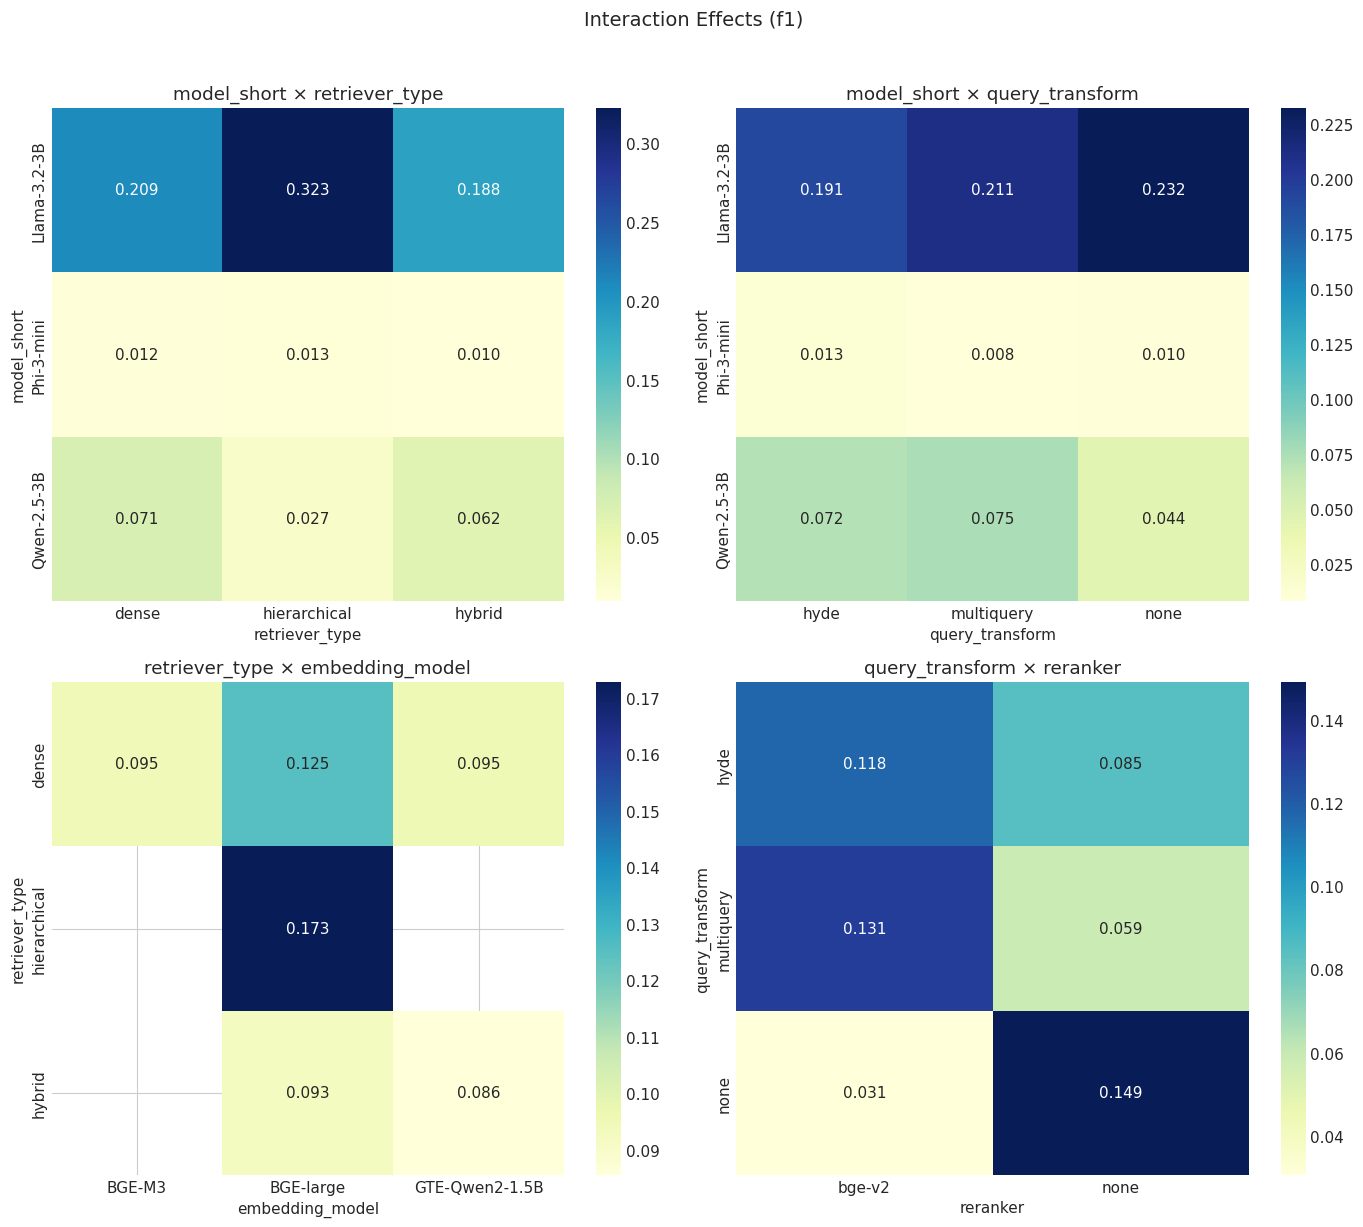

In [11]:
# Heatmaps for key interactions
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    rag_df = df[df['exp_type'] == 'rag']
    
    if len(rag_df) > 10:
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        
        interactions = [
            ('model_short', 'retriever_type'),
            ('model_short', 'query_transform'),
            ('retriever_type', 'embedding_model'),
            ('query_transform', 'reranker'),
        ]
        
        for ax, (row_dim, col_dim) in zip(axes.flatten(), interactions):
            if row_dim not in rag_df.columns or col_dim not in rag_df.columns:
                ax.set_visible(False)
                continue
            
            pivot = rag_df.pivot_table(
                index=row_dim, columns=col_dim, values=PRIMARY_METRIC, aggfunc='mean'
            )
            
            if pivot.empty:
                ax.set_visible(False)
                continue
            
            sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax)
            ax.set_title(f'{row_dim} × {col_dim}')
        
        plt.suptitle(f'Interaction Effects ({PRIMARY_METRIC})', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()

## 7. Prompt Strategy Analysis

Prompt Strategy Comparison


,prompt,mean,std,ci_low,ci_high,n,min,max
0,fewshot_3,0.1822,0.1758,0.1159,0.2527,25,0.0049,0.5664
1,concise,0.1284,0.1379,0.0774,0.1562,54,0.0063,0.4912
2,structured,0.1113,0.0854,0.0600,0.1402,17,0.0077,0.2502
3,cot,0.0188,0.0058,0.0164,0.0219,18,0.0093,0.0333


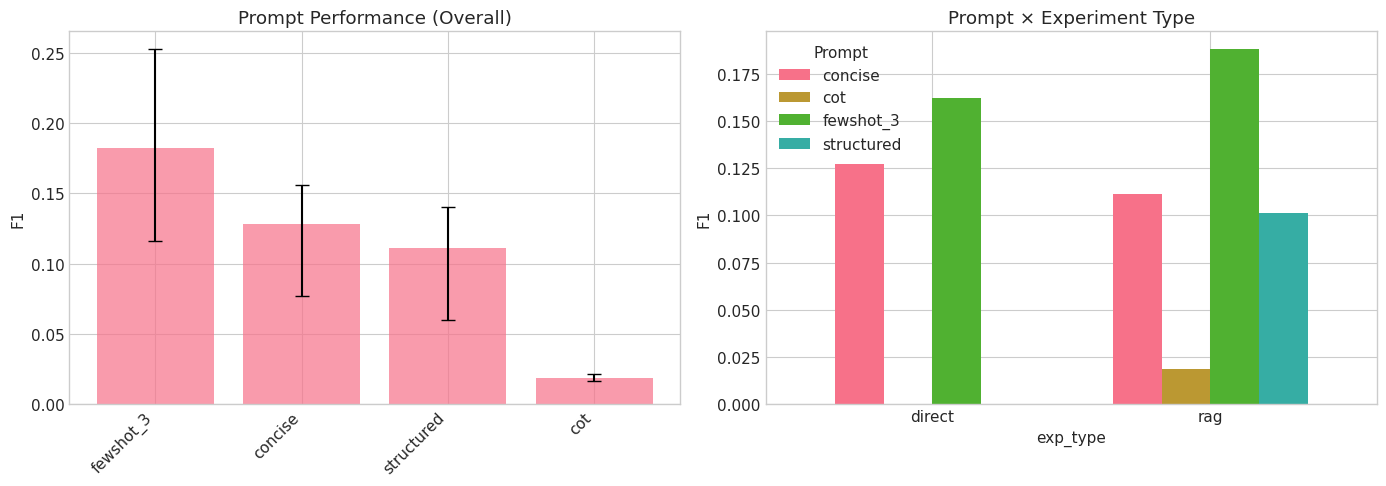

In [12]:
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    # Combine direct and RAG for prompt analysis
    prompt_stats = weighted_mean_with_ci(df, 'prompt', PRIMARY_METRIC, weight_by='dataset')
    
    if len(prompt_stats) > 0:
        print("Prompt Strategy Comparison")
        print("="*60)
        display(prompt_stats.round(4))
        
        # By experiment type
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Overall
        ax = axes[0]
        ax.bar(prompt_stats['prompt'], prompt_stats['mean'],
               yerr=[prompt_stats['mean'] - prompt_stats['ci_low'],
                     prompt_stats['ci_high'] - prompt_stats['mean']],
               capsize=5, alpha=0.7)
        ax.set_ylabel(PRIMARY_METRIC.upper())
        ax.set_title('Prompt Performance (Overall)')
        ax.set_xticklabels(prompt_stats['prompt'], rotation=45, ha='right')
        
        # By type (Direct vs RAG)
        ax = axes[1]
        type_prompt = df.groupby(['exp_type', 'prompt'])[PRIMARY_METRIC].mean().unstack()
        type_prompt.plot(kind='bar', ax=ax, width=0.7)
        ax.set_ylabel(PRIMARY_METRIC.upper())
        ax.set_title('Prompt × Experiment Type')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        ax.legend(title='Prompt')
        
        plt.tight_layout()
        plt.show()

## 8. Dataset-Specific Analysis

In [13]:
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    rag_df = df[df['exp_type'] == 'rag']
    
    print("Best Configurations per Dataset")
    print("="*60)
    
    for dataset in df['dataset'].dropna().unique():
        ds_df = rag_df[rag_df['dataset'] == dataset]
        if len(ds_df) == 0:
            continue
        
        best_idx = ds_df[PRIMARY_METRIC].idxmax()
        best = ds_df.loc[best_idx]
        
        print(f"\n{dataset.upper()}:")
        print(f"  Best {PRIMARY_METRIC}: {best[PRIMARY_METRIC]:.4f}")
        print(f"  Model: {best['model_short']}")
        print(f"  Retriever: {best.get('retriever_type', 'N/A')}")
        print(f"  Embedding: {best.get('embedding_model', 'N/A')}")
        print(f"  Query transform: {best.get('query_transform', 'none')}")
        print(f"  Reranker: {best.get('reranker', 'none')}")
        print(f"  Prompt: {best.get('prompt', 'N/A')}")

Best Configurations per Dataset

HOTPOTQA:
  Best f1: 0.1805
  Model: Llama-3.2-3B
  Retriever: hybrid
  Embedding: BGE-large
  Query transform: none
  Reranker: none
  Prompt: fewshot_3

NQ:
  Best f1: 0.2612
  Model: Llama-3.2-3B
  Retriever: dense
  Embedding: BGE-M3
  Query transform: hyde
  Reranker: bge-v2
  Prompt: fewshot_3

TRIVIAQA:
  Best f1: 0.5492
  Model: Llama-3.2-3B
  Retriever: hierarchical
  Embedding: BGE-large
  Query transform: none
  Reranker: none
  Prompt: fewshot_3


In [14]:
# Dataset difficulty comparison
if len(df) > 0 and PRIMARY_METRIC in df.columns:
    dataset_stats = weighted_mean_with_ci(df, 'dataset', PRIMARY_METRIC)
    
    print("\nDataset Difficulty (lower = harder)")
    print("="*60)
    display(dataset_stats.round(4))
    
    # Which strategies work best on hardest dataset?
    hardest = dataset_stats.iloc[-1]['dataset']
    print(f"\nStrategies on hardest dataset ({hardest}):")
    
    rag_df = df[(df['exp_type'] == 'rag') & (df['dataset'] == hardest)]
    if len(rag_df) > 0:
        for comp in ['retriever_type', 'query_transform', 'reranker']:
            if comp in rag_df.columns:
                stats = rag_df.groupby(comp)[PRIMARY_METRIC].mean().sort_values(ascending=False)
                best = stats.index[0]
                print(f"  Best {comp}: {best} ({stats.iloc[0]:.4f})")


Dataset Difficulty (lower = harder)


,dataset,mean,std,ci_low,ci_high,n,min,max
0,triviaqa,0.2020,0.1999,0.1277,0.2772,28,0.0127,0.5664
1,unknown,0.1273,0.1454,0.0455,0.2392,9,0.0158,0.4912
2,nq,0.0957,0.1050,0.0610,0.1334,36,0.0068,0.2612
3,hotpotqa,0.0594,0.0577,0.0420,0.0781,41,0.0049,0.1995



Strategies on hardest dataset (hotpotqa):
  Best retriever_type: hybrid (0.0666)
  Best query_transform: hyde (0.0612)
  Best reranker: none (0.0574)


## 9. Bottleneck Identification

In [15]:
def identify_bottlenecks(df: pd.DataFrame, metric: str = PRIMARY_METRIC) -> Dict[str, Any]:
    """
    Identify bottlenecks in the RAG pipeline.
    
    Returns analysis of where improvements would have biggest impact.
    """
    rag_df = df[df['exp_type'] == 'rag'].copy()
    if len(rag_df) < 10:
        return {}
    
    # Compute variance explained by each component
    total_var = rag_df[metric].var()
    
    variance_explained = {}
    components = ['model_short', 'retriever_type', 'embedding_model', 
                  'query_transform', 'reranker', 'prompt', 'top_k', 'dataset']
    
    for comp in components:
        if comp not in rag_df.columns:
            continue
        if rag_df[comp].dropna().nunique() < 2:
            continue
        
        # Between-group variance
        group_means = rag_df.groupby(comp)[metric].mean()
        grand_mean = rag_df[metric].mean()
        group_sizes = rag_df.groupby(comp).size()
        
        ss_between = sum(group_sizes[g] * (group_means[g] - grand_mean)**2 
                        for g in group_means.index)
        
        variance_explained[comp] = ss_between / (total_var * len(rag_df)) if total_var > 0 else 0
    
    # Sort by impact
    sorted_components = sorted(variance_explained.items(), key=lambda x: x[1], reverse=True)
    
    return {
        'variance_explained': dict(sorted_components),
        'top_bottleneck': sorted_components[0][0] if sorted_components else None,
        'total_experiments': len(rag_df),
    }


if len(df) > 0 and PRIMARY_METRIC in df.columns:
    bottlenecks = identify_bottlenecks(df)
    
    if bottlenecks:
        print("Bottleneck Analysis (Variance Explained)")
        print("="*60)
        print("Higher = more impact on performance variance\n")
        
        var_exp = bottlenecks['variance_explained']
        for comp, var in var_exp.items():
            bar = '█' * int(var * 50)
            print(f"{comp:20s} {var:6.1%} {bar}")
        
        print(f"\n🎯 Top bottleneck: {bottlenecks['top_bottleneck']}")
        print("   → Focus optimization efforts here for biggest gains")

Bottleneck Analysis (Variance Explained)
Higher = more impact on performance variance

model_short           42.6% █████████████████████
dataset               16.8% ████████
prompt                14.2% ███████
retriever_type         2.7% █
query_transform        2.2% █
embedding_model        1.2% 
top_k                  0.4% 
reranker               0.1% 

🎯 Top bottleneck: model_short
   → Focus optimization efforts here for biggest gains


## 10. Recommendations

In [16]:
def generate_recommendations(df: pd.DataFrame, metric: str = PRIMARY_METRIC):
    """Generate actionable recommendations based on analysis."""
    print("="*70)
    print("📋 RECOMMENDATIONS")
    print("="*70)
    
    rag_df = df[df['exp_type'] == 'rag']
    direct_df = df[df['exp_type'] == 'direct']
    
    if len(rag_df) == 0:
        print("Insufficient RAG experiments for recommendations.")
        return
    
    # 1. Best overall
    best_idx = rag_df[metric].idxmax()
    best = rag_df.loc[best_idx]
    print(f"\n1. BEST OVERALL CONFIGURATION ({metric}={best[metric]:.4f})")
    print(f"   Model: {best['model_short']}")
    print(f"   Retriever: {best.get('retriever_type', 'N/A')} / {best.get('embedding_model', 'N/A')}")
    print(f"   Query: {best.get('query_transform', 'none')}, Reranker: {best.get('reranker', 'none')}")
    print(f"   Prompt: {best.get('prompt', 'N/A')}, top_k: {best.get('top_k', 'N/A')}")
    
    # 2. Component recommendations
    effects_df = analyze_component_effects(df, metric)
    if len(effects_df) > 0:
        sig_positive = effects_df[(effects_df['significant']) & (effects_df['improvement'] > 0)]
        if len(sig_positive) > 0:
            print(f"\n2. SIGNIFICANT IMPROVEMENTS (p<0.05)")
            for _, row in sig_positive.head(5).iterrows():
                print(f"   ✓ {row['component']}: {row['baseline']} → {row['treatment']}")
                interp = 'negligible' if abs(row['effect_size']) < 0.2 else 'small' if abs(row['effect_size']) < 0.5 else 'medium' if abs(row['effect_size']) < 0.8 else 'large'
                print(f"     Effect: {row['improvement']:+.4f} ({interp})")
    
    # 3. Bottleneck
    bottlenecks = identify_bottlenecks(df, metric)
    if bottlenecks and bottlenecks['top_bottleneck']:
        print(f"\n3. PRIORITY FOR OPTIMIZATION")
        print(f"   Focus on: {bottlenecks['top_bottleneck']}")
        var = bottlenecks['variance_explained'].get(bottlenecks['top_bottleneck'], 0)
        print(f"   Explains {var:.1%} of performance variance")
    
    # 4. Dataset-specific
    print(f"\n4. DATASET-SPECIFIC INSIGHTS")
    for dataset in df['dataset'].dropna().unique():
        ds_rag = rag_df[rag_df['dataset'] == dataset]
        ds_direct = direct_df[direct_df['dataset'] == dataset]
        
        if len(ds_rag) > 0 and len(ds_direct) > 0:
            rag_best = ds_rag[metric].max()
            direct_best = ds_direct[metric].max()
            improvement = (rag_best - direct_best) / direct_best * 100 if direct_best > 0 else 0
            print(f"   {dataset}: RAG improves by {improvement:+.1f}% over direct")
    
    # 5. Quick wins
    print(f"\n5. QUICK WINS (low complexity, positive effect)")
    quick_wins = [
        ('prompt', 'Try structured or cot prompts'),
        ('reranker', 'Add bge-v2 reranker'),
        ('query_transform', 'Enable HyDE'),
    ]
    for comp, desc in quick_wins:
        if comp in effects_df['component'].values:
            comp_effects = effects_df[effects_df['component'] == comp]
            best_effect = comp_effects.iloc[0] if len(comp_effects) > 0 else None
            if best_effect is not None and best_effect['improvement'] > 0:
                print(f"   ✓ {desc}: +{best_effect['improvement']:.4f} {metric}")


if len(df) > 0 and PRIMARY_METRIC in df.columns:
    generate_recommendations(df)

📋 RECOMMENDATIONS

1. BEST OVERALL CONFIGURATION (f1=0.5492)
   Model: Llama-3.2-3B
   Retriever: hierarchical / BGE-large
   Query: none, Reranker: none
   Prompt: fewshot_3, top_k: 5.0


AttributeError: 'Series' object has no attribute 'ttest_ind'

## 11. Export Analysis Results

In [ ]:
if len(df) > 0:
    output_dir = STUDY_PATH / "analysis"
    output_dir.mkdir(exist_ok=True)
    
    # Full results
    df.to_csv(output_dir / "full_results.csv", index=False)
    
    # Component effects
    if PRIMARY_METRIC in df.columns:
        effects_df = analyze_component_effects(df)
        if len(effects_df) > 0:
            effects_df.to_csv(output_dir / "component_effects.csv", index=False)
    
    # Bottleneck analysis
    bottlenecks = identify_bottlenecks(df)
    if bottlenecks:
        with open(output_dir / "bottleneck_analysis.json", 'w') as f:
            json.dump(bottlenecks, f, indent=2)
    
    print(f"Results exported to: {output_dir}")